In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

### Helper Functions

In [3]:
def data_quality_report_latex(df, caption="Data Quality Report", label="tab:data_quality"):
    """
    Generate a LaTeX table summarizing data quality for continuous (numeric) features in a DataFrame.
    """
    # Try to convert all columns to numeric, non-convertible entries become NaN
    df_numeric = df.apply(pd.to_numeric, errors='coerce')
    numeric_df = df_numeric.select_dtypes(include=[np.number])

    if numeric_df.empty:
        return "% No numeric columns found in DataFrame.\n"

    report = pd.DataFrame({
        "Feature": numeric_df.columns+1,
        "Count": numeric_df.shape[0],
        "% Miss.": numeric_df.isnull().sum().values / numeric_df.shape[0] * 100,
        "Card.": numeric_df.nunique().values,
        "Min.": numeric_df.min().values,
        "1st Qrt.": numeric_df.quantile(0.25).values,
        "Mean": numeric_df.mean().values,
        "Median": numeric_df.median().values,
        "3rd Qrt.": numeric_df.quantile(0.75).values,
        "Max.": numeric_df.max().values,
        "Std. Dev.": numeric_df.std().values
    })

    # Format as LaTeX
    latex = report.to_latex(
        index=False,
        float_format="%.2f",
        column_format="|l|" + "r|" * (len(report.columns) - 1),
        caption=caption,
        label=label
    )
    
    return latex


In [4]:
def categorical_data_quality_report_latex(df, caption="Categorical Data Quality Report", label="tab:categorical_quality"):
    """
    Generate a LaTeX table summarizing data quality for categorical features in a DataFrame.
    Treats '?' as a missing value. Correctly computes % missing and counts.
    """
    # If upstream read_csv used na_values='?', this is redundant but harmless
    df = df.replace('?', np.nan)

    # Select only object and category columns
    cat_df = df.select_dtypes(include=["object", "category"])

    if cat_df.empty:
        return "% No categorical columns found in DataFrame.\n"

    data = []

    for col in cat_df.columns:
        series = cat_df[col]
        total = len(series)
        missing = series.isna().sum()
        non_missing = total - missing
        pct_miss = (missing / total * 100) if total > 0 else 0.0
        cardinality = series.nunique(dropna=True)

        # Value counts excluding NaNs (default behaviour)
        value_counts = series.value_counts(dropna=True)

        if non_missing > 0 and not value_counts.empty:
            mode = value_counts.index[0]
            mode_freq = int(value_counts.iloc[0])
            mode_pct = (mode_freq / non_missing * 100)
        else:
            mode, mode_freq, mode_pct = "", 0, 0.0

        if len(value_counts) > 1:
            second_mode = value_counts.index[1]
            second_mode_freq = int(value_counts.iloc[1])
            second_mode_pct = (second_mode_freq / non_missing * 100) if non_missing > 0 else 0.0
        else:
            second_mode, second_mode_freq, second_mode_pct = "", 0, 0.0

        # Append row (feature index shown as col+1 if columns are numeric; if not numeric you'll just show label)
        feature_label = col + 1 if isinstance(col, (int, float, np.integer)) else col
        data.append([
            feature_label, non_missing, pct_miss, cardinality,
            mode, mode_freq, mode_pct,
            second_mode, second_mode_freq, second_mode_pct
        ])

    report = pd.DataFrame(data, columns=[
        "Feature", "count", "%miss", "Card",
        "Mode", "Mode Freq.", "Mode %",
        "2nd Mode", "2nd Mode Freq", "2nd Mode %"
    ])

    # Format LaTeX table
    latex = report.to_latex(
        index=False,
        float_format="%.2f",
        column_format="|l|r|r|r|l|r|r|l|r|r|",
        caption=caption,
        label=label,
        escape=True
    )

    return latex

# Task 1

In [5]:
df = pd.read_csv("badDataSet.csv", delimiter='\t', header=None, na_values='?')

In [6]:
df_noTarget = df.iloc[:, :-1]

In [7]:
df

,0,1,2,3,4,5,6,7,8,9,...,53,54,55,56,57,58,59,60,61,62
0,4264440.30,89.0,222.711631,11.0,785.0,81.916660,-0.613049,4352,237.0,222,...,0,0,0,0,0,0,1,1,1,7.0
1,4264440.30,4.0,10.035728,15.0,849.0,81.973876,-0.791090,4413,199.0,209,...,0,0,0,0,0,0,1,2,1,7.0
2,4263334.95,342.0,855.348205,16.0,870.0,81.035217,0.519791,4443,186.0,214,...,0,0,0,0,0,0,1,3,1,7.0
3,4262229.60,24.0,60.238933,15.0,828.0,80.054099,0.432647,4383,211.0,208,...,0,0,0,0,0,0,1,4,1,7.0
4,4258913.55,338.0,847.158476,15.0,892.0,77.054464,-0.923799,4473,187.0,218,...,0,0,0,0,0,0,1,5,1,7.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
581007,2062583.10,23.0,57.594866,14.0,85.0,16.059535,-0.103136,108,212.0,210,...,0,0,0,0,0,0,0,581008,1,3.0
581008,2059267.05,37.0,92.585707,17.0,120.0,17.977536,0.417243,90,217.0,202,...,0,0,0,0,0,0,0,581009,1,6.0
581009,2057056.35,35.0,87.547136,14.0,60.0,10.962117,0.902718,85,218.0,209,...,0,0,0,0,0,0,0,581010,1,3.0
581010,2055951.00,18.0,45.141729,13.0,95.0,14.972901,-0.202035,90,210.0,213,...,0,0,0,0,0,0,0,581011,1,3.0


In [8]:
df_noTarget

,0,1,2,3,4,5,6,7,8,9,...,52,53,54,55,56,57,58,59,60,61
0,4264440.30,89.0,222.711631,11.0,785.0,81.916660,-0.613049,4352,237.0,222,...,0,0,0,0,0,0,0,1,1,1
1,4264440.30,4.0,10.035728,15.0,849.0,81.973876,-0.791090,4413,199.0,209,...,0,0,0,0,0,0,0,1,2,1
2,4263334.95,342.0,855.348205,16.0,870.0,81.035217,0.519791,4443,186.0,214,...,0,0,0,0,0,0,0,1,3,1
3,4262229.60,24.0,60.238933,15.0,828.0,80.054099,0.432647,4383,211.0,208,...,0,0,0,0,0,0,0,1,4,1
4,4258913.55,338.0,847.158476,15.0,892.0,77.054464,-0.923799,4473,187.0,218,...,0,0,0,0,0,0,0,1,5,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
581007,2062583.10,23.0,57.594866,14.0,85.0,16.059535,-0.103136,108,212.0,210,...,0,0,0,0,0,0,0,0,581008,1
581008,2059267.05,37.0,92.585707,17.0,120.0,17.977536,0.417243,90,217.0,202,...,0,0,0,0,0,0,0,0,581009,1
581009,2057056.35,35.0,87.547136,14.0,60.0,10.962117,0.902718,85,218.0,209,...,0,0,0,0,0,0,0,0,581010,1
581010,2055951.00,18.0,45.141729,13.0,95.0,14.972901,-0.202035,90,210.0,213,...,0,0,0,0,0,0,0,0,581011,1


In [9]:
df.nunique().sort_values().tail(20)


20         2
21         2
22         2
49         2
48         2
17         3
62         7
3         67
9        186
8        207
10       255
1        361
4        569
0       1978
7       5811
11      5826
2     576099
6     577988
5     581012
60    581012
dtype: int64

In [10]:
print(df.iloc[:, 9].value_counts(dropna=False))


9
231    13482
228    13474
233    13097
230    13092
229    13077
       ...  
71         1
81         1
78         1
74         1
76         1
Name: count, Length: 187, dtype: int64


In [11]:
print(df.iloc[:, 9].unique())


['222' '209' '214' '208' '218' '206' '220' '224' '205' '227' '213' '237'
 '234' '233' '226' '216' '235' '229' '219' '223' '230' '228' '225' '207'
 '232' '201' '200' '217' '202' 'a' '215' '211' '212' '231' '210' '221'
 '203' '198' '199' nan '189' '204' '197' '196' '193' '194' '195' '191'
 '236' '238' '239' '245' '248' '249' '192' '247' '186' '180' '188' '190'
 '242' '184' '178' '182' '171' '177' '173' '183' '164' '246' '240' '167'
 '241' '156' '160' '165' '243' '168' '153' '187' '250' '185' '175' '163'
 '244' '176' '157' '172' '150' '161' '170' '179' '152' '166' '169' '158'
 '162' '145' '174' '181' '254' '159' '253' '155' '251' '154' '147' '252'
 '148' '149' '151' '140' '144' '142' '130' '136' '111' '120' '146' '110'
 '143' '104' '133' '100' '134' '139' '124' '115' '99' '125' '112' '141'
 '114' '119' '122' '135' '126' '132' '128' '123' '129' '121' '138' '117'
 '118' '131' '107' '98' '113' '137' '42' '101' '95' '90' '102' '85' '116'
 '80' '109' '105' '81' '74' '91' '106' '68' '93' '108' 

In [12]:
# investigate what is the likely value of a

# Get unique numeric values (ignoring 'a' and NaN)
vals = pd.to_numeric(df.iloc[:, 9], errors='coerce').dropna().astype(int).unique()

# Find missing numbers in 0–255
missing = set(range(256)) - set(vals)

print(missing)

{1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 31, 32, 33, 34, 35, 36, 37, 38, 39, 41, 43, 44, 46, 47, 48, 49, 50, 51, 52, 54, 55, 56, 57, 58, 59, 60, 61, 62, 65, 66, 67, 69, 70, 72, 73, 77, 79, 83, 84, 86, 94, 255}


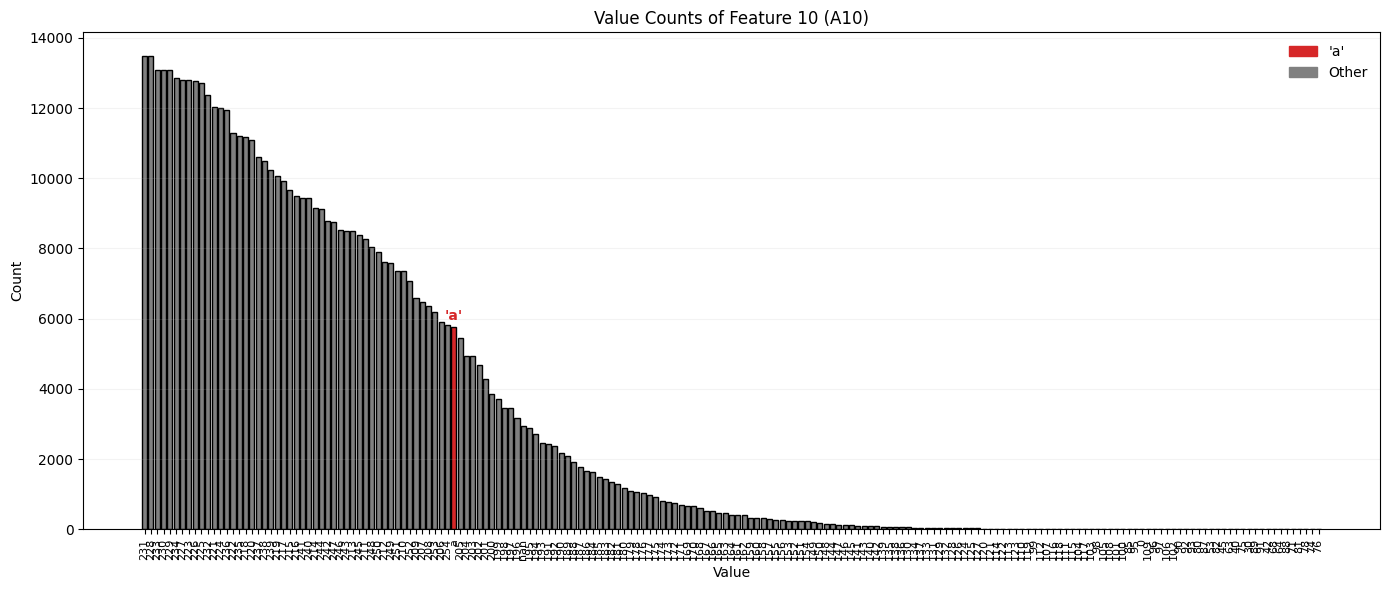

In [13]:
# bar plot of A10 highlighting the value 'a'
feature = df.columns[9]
series = df[feature]
value_counts = series.value_counts(dropna=False)

import matplotlib.patches as mpatches
colors = ['tab:red' if str(idx) == 'a' else 'grey' for idx in value_counts.index]

plt.figure(figsize=(14, 6))
plt.bar([str(x) for x in value_counts.index], value_counts.values, color=colors, edgecolor='black')
plt.xlabel('Value')
plt.ylabel('Count')
plt.title(f'Value Counts of Feature {feature+1} (A10)')
plt.grid(axis='y', alpha=0.15)
plt.xticks(rotation=90, fontsize=8)

# Annotate the 'a' bar if present
if 'a' in value_counts.index:
    idx = list(value_counts.index).index('a')
    plt.annotate("'a'", (idx, value_counts.values[idx]), xytext=(0, 5), textcoords='offset points',
                 ha='center', color='tab:red', fontweight='bold')

legend_handles = []
if 'a' in value_counts.index:
    legend_handles.append(mpatches.Patch(color='tab:red', label="'a'"))
legend_handles.append(mpatches.Patch(color='grey', label='Other'))
plt.legend(handles=legend_handles, frameon=False)

plt.tight_layout()
plt.savefig(f'report/images/{feature+1}_barplot.pdf', dpi=300)
plt.show()

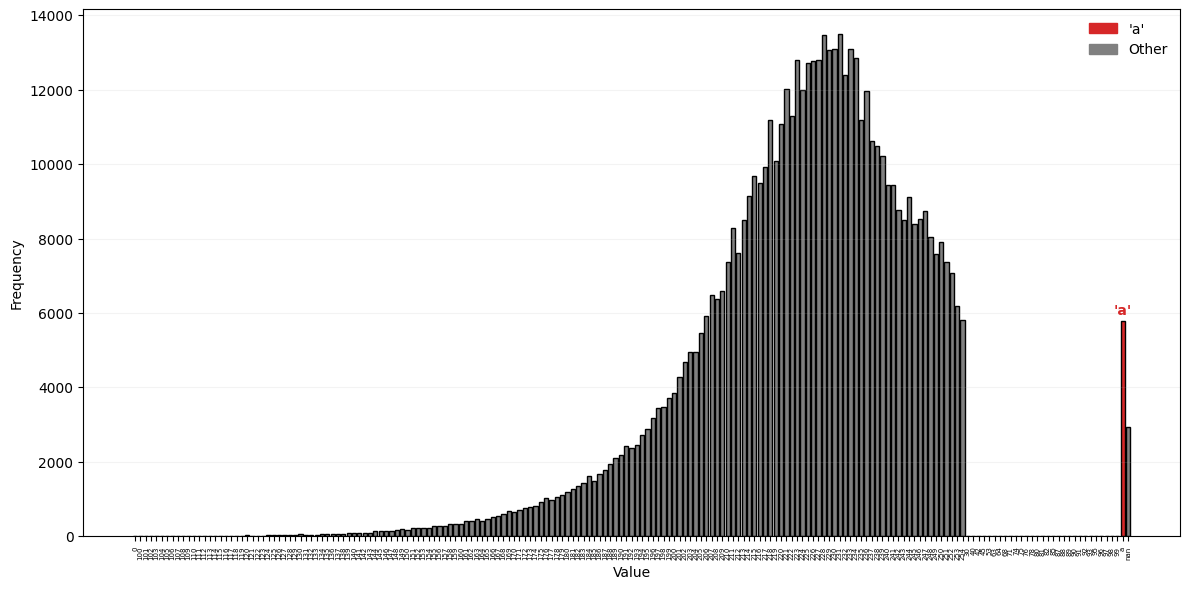

In [14]:
# bar plot of A10 distribution with 'a' highlighted and sorted x-axis
feature = df.columns[9] 
series = df[feature]
value_counts = series.value_counts(dropna=False)

# Sort the value_counts by index (the actual values)
value_counts = value_counts.sort_index()

import matplotlib.patches as mpatches
colors = ['tab:red' if str(idx) == 'a' else 'grey' for idx in value_counts.index]

plt.figure(figsize=(12, 6))
plt.bar([str(x) for x in value_counts.index], value_counts.values, color=colors, edgecolor='black')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.15)
plt.xticks(rotation=90, fontsize=5)

# Annotate the 'a' bar if present
if 'a' in value_counts.index:
    idx = list(value_counts.index).index('a')
    plt.annotate("'a'", (idx, value_counts.values[idx]), xytext=(0, 5), textcoords='offset points',
                 ha='center', color='tab:red', fontweight='bold')

legend_handles = []
if 'a' in value_counts.index:
    legend_handles.append(mpatches.Patch(color='tab:red', label="'a'"))
legend_handles.append(mpatches.Patch(color='grey', label='Other'))
plt.legend(handles=legend_handles, frameon=False)

plt.tight_layout()
plt.savefig(f'report/images/{feature+1}_distribution.pdf', dpi=300)
plt.show()

In [15]:
# how many observation have the value 'a' in A10
col_name = df.columns[9]  # 0-indexed
count_a_in_A10 = (df[col_name] == 'a').sum()
print(f"Number of observations with {col_name} == 'a': {count_a_in_A10}")
# percentage of A10 that is 'a'
percentage_a_in_A10 = (count_a_in_A10 / len(df)) * 100
print(f"Percentage of {col_name} that is 'a': {percentage_a_in_A10:.2f}%")


Number of observations with 9 == 'a': 5770
Percentage of 9 that is 'a': 0.99%


### Split the DataFrame into continuous and categorical features

In [16]:
# use a threshold of 20 to split the DataFrame into continuous and categorical features
threshold = 20

# Initial split by cardinality
df_categorical = df_noTarget.loc[:, df_noTarget.nunique(dropna=True) <= threshold]
df_continuous = df_noTarget.loc[:, df_noTarget.nunique(dropna=True) > threshold]

# Force A10 (10th column, index 9) to be categorical regardless of cardinality
a10_col = df.columns[9]
if a10_col in df_noTarget.columns:
    # Add to categorical if not already there
    if a10_col not in df_categorical.columns:
        df_categorical = pd.concat([df_categorical, df_noTarget[[a10_col]]], axis=1)
    # Remove from continuous if present
    if a10_col in df_continuous.columns:
        df_continuous = df_continuous.drop(columns=[a10_col])

# Reorder columns if you want original order preserved
df_categorical = df_noTarget.loc[:, [c for c in df_noTarget.columns if c in df_categorical.columns]]

In [17]:
# convert numerical columns to 'category' dtype
df_categorical = df_categorical.apply(lambda x: x.astype('category') if x.dtype == 'float64' else x)
df_categorical = df_categorical.apply(lambda x: x.astype('category') if x.dtype == 'int64' else x)



In [18]:
df_continuous

,0,1,2,3,4,5,6,7,8,10,11,60
0,4264440.30,89.0,222.711631,11.0,785.0,81.916660,-0.613049,4352,237.0,115,2402.0,1
1,4264440.30,4.0,10.035728,15.0,849.0,81.973876,-0.791090,4413,199.0,146,2468.0,2
2,4263334.95,342.0,855.348205,16.0,870.0,81.035217,0.519791,4443,186.0,166,2497.0,3
3,4262229.60,24.0,60.238933,15.0,828.0,80.054099,0.432647,4383,211.0,130,2440.0,4
4,4258913.55,338.0,847.158476,15.0,892.0,77.054464,-0.923799,4473,187.0,170,2526.0,5
...,...,...,...,...,...,...,...,...,...,...,...,...
581007,2062583.10,23.0,57.594866,14.0,85.0,16.059535,-0.103136,108,212.0,133,819.0,581008
581008,2059267.05,37.0,92.585707,17.0,120.0,17.977536,0.417243,90,217.0,115,769.0,581009
581009,2057056.35,35.0,87.547136,14.0,60.0,10.962117,0.902718,85,218.0,124,832.0,581010
581010,2055951.00,18.0,45.141729,13.0,95.0,14.972901,-0.202035,90,210.0,138,780.0,581011


In [19]:
df_categorical.dtypes

9       object
12    category
13    category
14    category
15    category
16    category
17    category
18    category
19    category
20    category
21    category
22    category
23    category
24    category
25    category
26    category
27    category
28    category
29    category
30    category
31    category
32    category
33    category
34    category
35    category
36    category
37    category
38    category
39    category
40    category
41    category
42    category
43    category
44    category
45    category
46    category
47    category
48    category
49    category
50    category
51    category
52    category
53    category
54    category
55    category
56    category
57    category
58    category
59    category
61    category
dtype: object

### Get reports

In [20]:
latex_table = data_quality_report_latex(df_continuous)

In [21]:
print(latex_table)

\begin{table}
\caption{Data Quality Report}
\label{tab:data_quality}
\begin{tabular}{|l|r|r|r|r|r|r|r|r|r|r|}
\toprule
Feature & Count & % Miss. & Card. & Min. & 1st Qrt. & Mean & Median & 3rd Qrt. & Max. & Std. Dev. \\
\midrule
1 & 581012 & 0.00 & 1978 & 2054845.65 & 3104928.15 & 3271134.43 & 3311628.60 & 3496222.05 & 4264440.30 & 309481.13 \\
2 & 581012 & 0.51 & 361 & 0.00 & 58.00 & 155.66 & 127.00 & 260.00 & 360.00 & 111.91 \\
3 & 581012 & 0.00 & 576099 & 0.00 & 145.49 & 389.92 & 318.12 & 652.53 & 903.48 & 280.34 \\
4 & 581012 & 0.05 & 67 & 0.00 & 9.00 & 14.10 & 13.00 & 18.00 & 66.00 & 7.49 \\
5 & 581012 & 0.51 & 569 & -691.00 & 108.00 & 269.42 & 218.00 & 384.00 & 1397.00 & 212.56 \\
6 & 581012 & 0.00 & 581012 & -173.07 & 6.99 & 46.42 & 29.91 & 68.97 & 600.95 & 58.30 \\
7 & 581012 & 0.51 & 577988 & -1.00 & -0.50 & -0.00 & -0.00 & 0.50 & 1.00 & 0.58 \\
8 & 581012 & 0.00 & 5811 & 0.00 & 1106.00 & 8158.11 & 1997.00 & 3328.00 & 510165098.00 & 1185156.02 \\
9 & 581012 & 0.51 & 207 & 0.00

In [22]:
# get categorical data quality report
latex_cat_table = categorical_data_quality_report_latex(df_categorical)
print(latex_cat_table)

\begin{table}
\caption{Categorical Data Quality Report}
\label{tab:categorical_quality}
\begin{tabular}{|l|r|r|r|l|r|r|l|r|r|}
\toprule
Feature & count & \%miss & Card & Mode & Mode Freq. & Mode \% & 2nd Mode & 2nd Mode Freq & 2nd Mode \% \\
\midrule
10 & 578069 & 0.51 & 186 & 231 & 13482 & 2.33 & 228 & 13474 & 2.33 \\
13 & 578069 & 0.51 & 2 & 0.00 & 318579 & 55.11 & 1.00 & 259490 & 44.89 \\
14 & 581012 & 0.00 & 2 & 0 & 551128 & 94.86 & 1 & 29884 & 5.14 \\
15 & 581012 & 0.00 & 2 & 0 & 327648 & 56.39 & 1 & 253364 & 43.61 \\
16 & 578069 & 0.51 & 1 & 0.00 & 578069 & 100.00 &  & 0 & 0.00 \\
17 & 581012 & 0.00 & 1 & 0 & 581012 & 100.00 &  & 0 & 0.00 \\
18 & 578069 & 0.51 & 3 & 0.00 & 538608 & 93.17 & 1.00 & 36589 & 6.33 \\
19 & 581012 & 0.00 & 2 & 0 & 291278 & 50.13 & 1 & 289734 & 49.87 \\
20 & 577566 & 0.59 & 2 & 0.00 & 574553 & 99.48 & 1.00 & 3013 & 0.52 \\
21 & 173355 & 70.16 & 2 & 0.00 & 172455 & 99.48 & 1.00 & 900 & 0.52 \\
22 & 581012 & 0.00 & 2 & 0 & 573487 & 98.70 & 1 & 7525 & 1.30 

---

In [23]:
target = df.iloc[:, -1]

In [24]:
np.count_nonzero(target == "?")


0

In [25]:
target = np.where(target == "?", np.nan, target)

In [26]:
target_df = pd.DataFrame(target)

### Get target variable table

In [27]:
# convert to categorical dtype
target_df = target_df.apply(lambda x: x.astype('category') if x.dtype == 'float64' else x)

In [28]:
latex_table = categorical_data_quality_report_latex(target_df)

In [29]:
latex_table

'\\begin{table}\n\\caption{Categorical Data Quality Report}\n\\label{tab:categorical_quality}\n\\begin{tabular}{|l|r|r|r|l|r|r|l|r|r|}\n\\toprule\nFeature & count & \\%miss & Card & Mode & Mode Freq. & Mode \\% & 2nd Mode & 2nd Mode Freq & 2nd Mode \\% \\\\\n\\midrule\n1 & 580952 & 0.01 & 7 & 2.00 & 283269 & 48.76 & 1.00 & 211815 & 36.46 \\\\\n\\bottomrule\n\\end{tabular}\n\\end{table}\n'

In [30]:
duplicates = df[df.duplicated()]
duplicates

,0,1,2,3,4,5,6,7,8,9,...,53,54,55,56,57,58,59,60,61,62


# Task 2

In [31]:
df

,0,1,2,3,4,5,6,7,8,9,...,53,54,55,56,57,58,59,60,61,62
0,4264440.30,89.0,222.711631,11.0,785.0,81.916660,-0.613049,4352,237.0,222,...,0,0,0,0,0,0,1,1,1,7.0
1,4264440.30,4.0,10.035728,15.0,849.0,81.973876,-0.791090,4413,199.0,209,...,0,0,0,0,0,0,1,2,1,7.0
2,4263334.95,342.0,855.348205,16.0,870.0,81.035217,0.519791,4443,186.0,214,...,0,0,0,0,0,0,1,3,1,7.0
3,4262229.60,24.0,60.238933,15.0,828.0,80.054099,0.432647,4383,211.0,208,...,0,0,0,0,0,0,1,4,1,7.0
4,4258913.55,338.0,847.158476,15.0,892.0,77.054464,-0.923799,4473,187.0,218,...,0,0,0,0,0,0,1,5,1,7.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
581007,2062583.10,23.0,57.594866,14.0,85.0,16.059535,-0.103136,108,212.0,210,...,0,0,0,0,0,0,0,581008,1,3.0
581008,2059267.05,37.0,92.585707,17.0,120.0,17.977536,0.417243,90,217.0,202,...,0,0,0,0,0,0,0,581009,1,6.0
581009,2057056.35,35.0,87.547136,14.0,60.0,10.962117,0.902718,85,218.0,209,...,0,0,0,0,0,0,0,581010,1,3.0
581010,2055951.00,18.0,45.141729,13.0,95.0,14.972901,-0.202035,90,210.0,213,...,0,0,0,0,0,0,0,581011,1,3.0


In [32]:
df[7]

0         4352
1         4413
2         4443
3         4383
4         4473
          ... 
581007     108
581008      90
581009      85
581010      90
581011      90
Name: 7, Length: 581012, dtype: int64

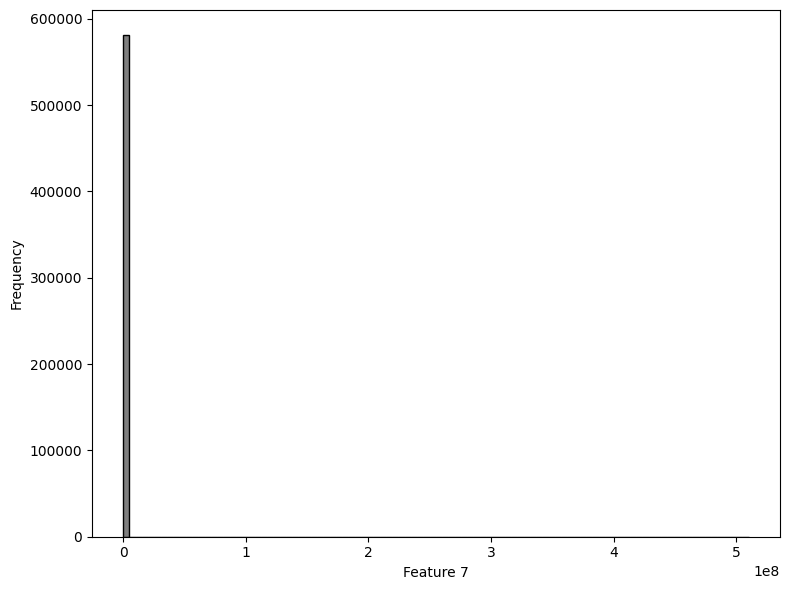

In [33]:
plt.figure(figsize=(8, 6))
df[7].hist(bins=100, edgecolor='black', color='grey')
plt.xlabel('Feature 7')
plt.ylabel('Frequency')
plt.grid(False)
plt.tight_layout()
plt.savefig('report/images/8_distribution.pdf', dpi=300)
plt.show()

/tmp/ipykernel_7394/3595119592.py:11: UserWarning: Tight layout not applied. tight_layout cannot make Axes height small enough to accommodate all Axes decorations.
  plt.tight_layout()


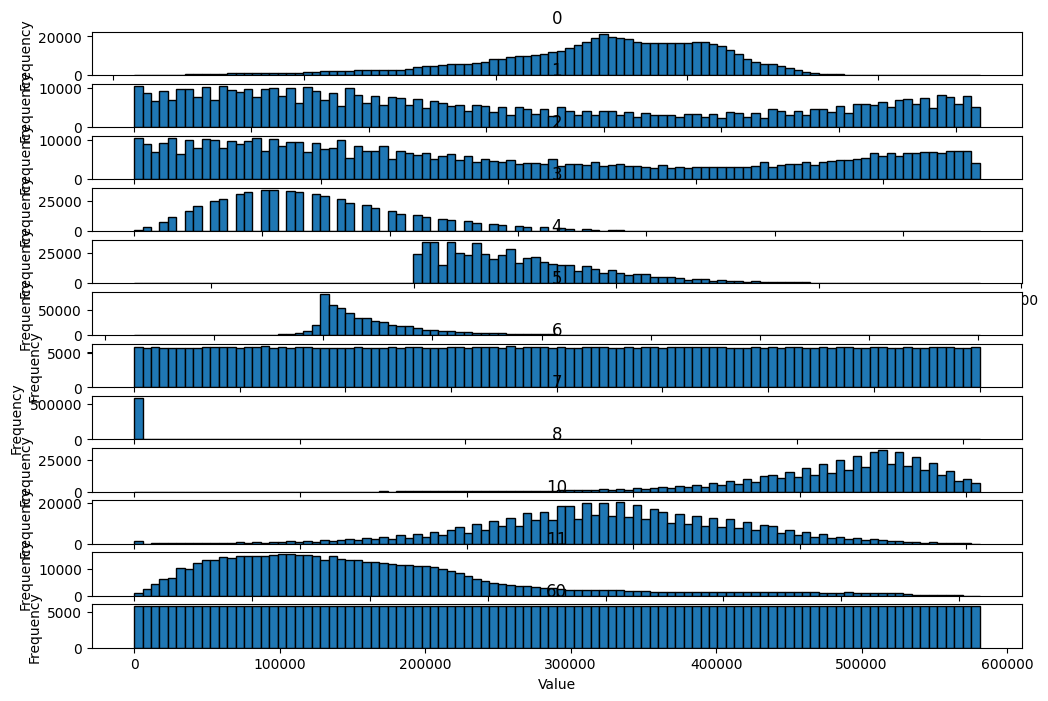

In [34]:
# plot distribution of all continuous features
continuous_features = df_continuous.columns
plt.figure(figsize=(12, 8))
for i, feature in enumerate(continuous_features):
    plt.subplot(len(continuous_features), 1, i + 1)
    df[feature].hist(bins=100, edgecolor='black')
    plt.title(feature)
    plt.xlabel('Value')
    plt.ylabel('Frequency')
    plt.grid(False)
plt.tight_layout()
plt.savefig('report/images/continuous_features_distribution.pdf', dpi=300)
plt.show()

In [35]:
continuous_features.shape

(12,)

In [36]:
df[60]

0              1
1              2
2              3
3              4
4              5
           ...  
581007    581008
581008    581009
581009    581010
581010    581011
581011    581012
Name: 60, Length: 581012, dtype: int64

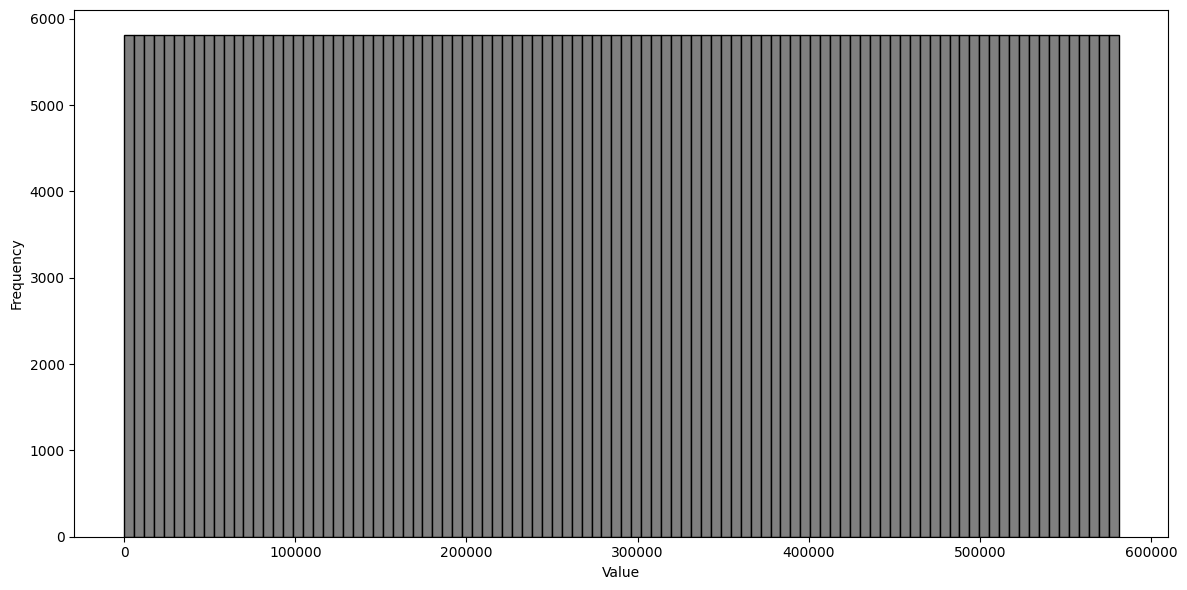

In [37]:
# plot distribution of feature 61
feature = continuous_features[11]  # 12th index is 60
plt.figure(figsize=(12, 6))
df[feature].hist(bins=100, edgecolor='black', color='grey')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.grid(False)
plt.tight_layout()
plt.savefig(f'report/images/{feature+1}_distribution.pdf', dpi=300)
plt.show()

In [38]:
# find variance of feature 60
df[60].var()

28131293763.0

In [39]:
(df[60] == df.index+1).all()

True

In [40]:
df[1]

0          89.0
1           4.0
2         342.0
3          24.0
4         338.0
          ...  
581007     23.0
581008     37.0
581009     35.0
581010     18.0
581011     18.0
Name: 1, Length: 581012, dtype: float64

## Task 3

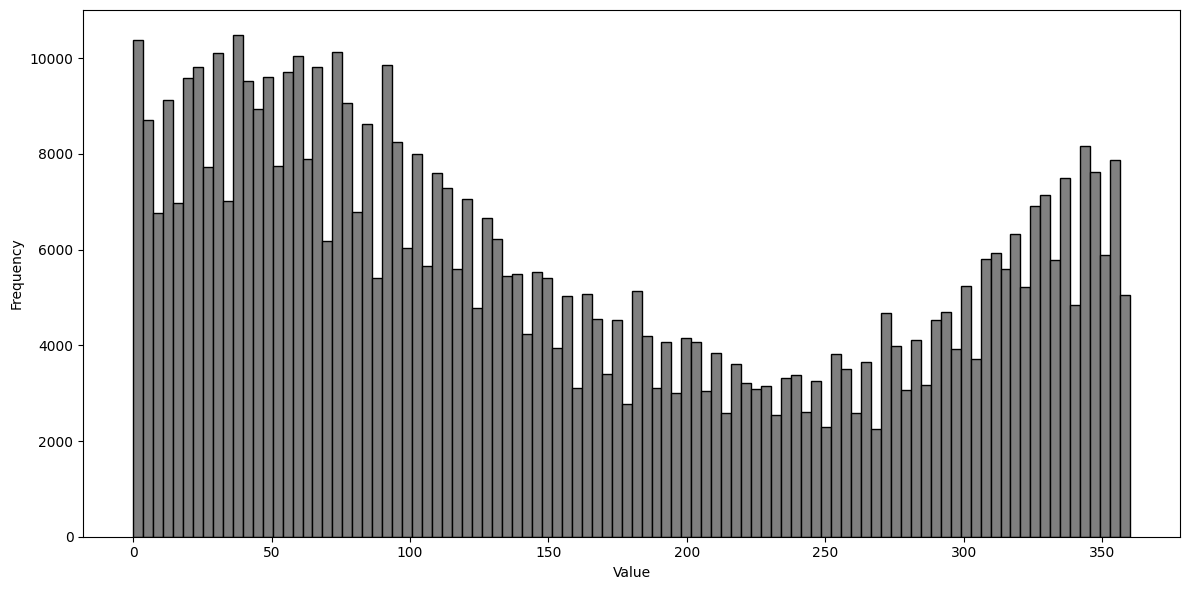

In [41]:
# plot distribution of A2
feature = df.columns[1] 
plt.figure(figsize=(12, 6))
df[feature].hist(bins=100, edgecolor='black', color='grey')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.grid(False)
plt.tight_layout()
plt.savefig(f'report/images/{feature+1}_distribution.pdf', dpi=300)
plt.show()

In [42]:
feature = df.columns[7]

# Summary stats
print(df[feature].describe())

# Percentiles for a better picture
for p in [50, 75, 90, 95, 99, 99.9]:
    print(f"{p}th percentile:", np.percentile(df[feature], p))

# How many above certain thresholds
thresholds = [5e7, 5e8]
for t in thresholds:
    print(f"Count > {t}: {(df[feature] > t).sum()}")

count    5.810120e+05
mean     8.158108e+03
std      1.185156e+06
min      0.000000e+00
25%      1.106000e+03
50%      1.997000e+03
75%      3.328000e+03
max      5.101651e+08
Name: 7, dtype: float64
50th percentile: 1997.0
75th percentile: 3328.0
90th percentile: 4793.0
95th percentile: 5484.0
99th percentile: 6113.0
99.9th percentile: 6699.0
Count > 50000000.0: 18
Count > 500000000.0: 1


In [43]:
len(df)

581012

In [44]:
# investigate the missingness of A10
col_name = df.columns[9]  # 0-indexed
missing_count = df[col_name].isna().sum()
missing_percent = (missing_count / len(df)) * 100

print(f"Column name: {col_name}")
print(f"Missing count: {missing_count}")
print(f"Missing percent: {missing_percent:.2f}%")


Column name: 9
Missing count: 2943
Missing percent: 0.51%


In [45]:
# get datatype of A10
print(f"Data type of {col_name}: {df[col_name].dtype}")

Data type of 9: object


In [46]:
# determine whether missingness of A21 should be treated as a separate category, that is find correlation between missingness target
col_name = df.columns[20]  # 21st column, 0-indexed
missing_A21 = df[col_name].isna()
target_missing = target_df.isna().squeeze()
correlation = missing_A21.corr(target_missing)
print(f"Correlation between missingness of {col_name} and target: {correlation:.4f}")

Correlation between missingness of 20 and target: -0.0004


In [47]:
target_df
# check if any observation have "?" in target
target_df[target_df == "?"].count()

0    0
dtype: int64

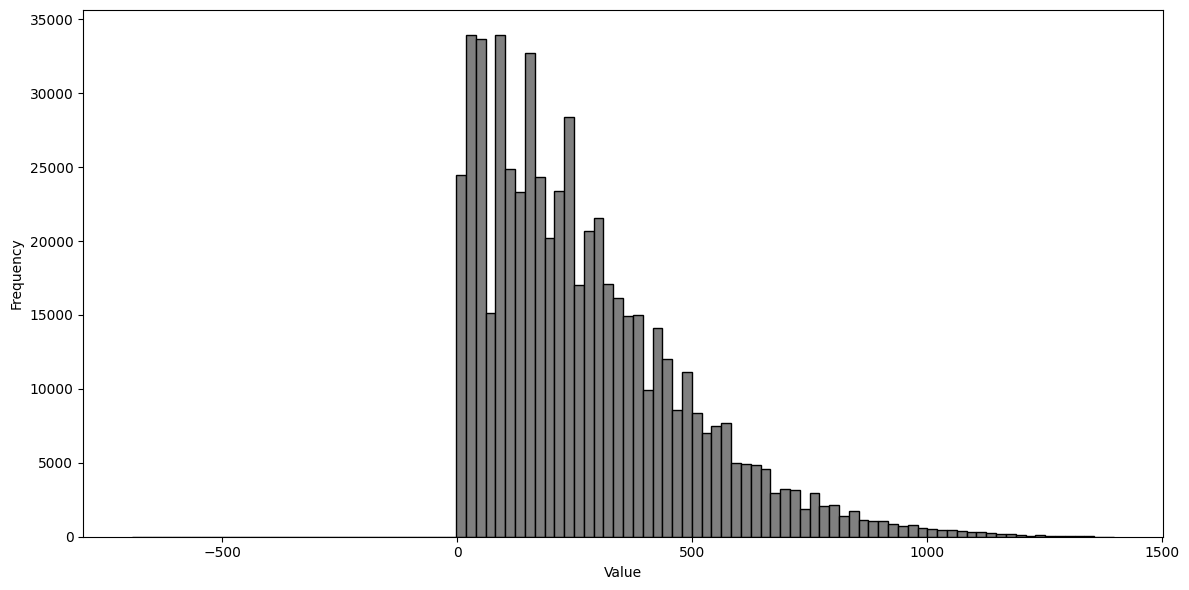

In [48]:
# plot distribution of A5
feature = df.columns[4] 
plt.figure(figsize=(12, 6))
df[feature].hist(bins=100, edgecolor='black', color='grey')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.grid(False)
plt.tight_layout()
plt.savefig(f'report/images/{feature+1}_distribution.pdf', dpi=300)
plt.show()

In [49]:
# count how many negative A5
df_negative_A5 = df[df[4] < 0]
df_negative_A5_count = df_negative_A5.shape[0]
df_negative_A5_count

26

In [50]:
# how many of A5 is less than 0
count_less_than_0 = (df[feature] < 0).sum()
print(f"Number of observations with {feature} < 0: {count_less_than_0}")

# give values of A5 that are less than 0
values_less_than_0 = df[feature][df[feature] < 0].unique()
print(f"Values of {feature} that are less than 0: {values_less_than_0}")

Number of observations with 4 < 0: 26
Values of 4 that are less than 0: [-576.  -30. -691.  -60. -342. -108.  -95. -570. -685. -247. -242. -162.
 -153. -684. -618. -277. -313. -120.]


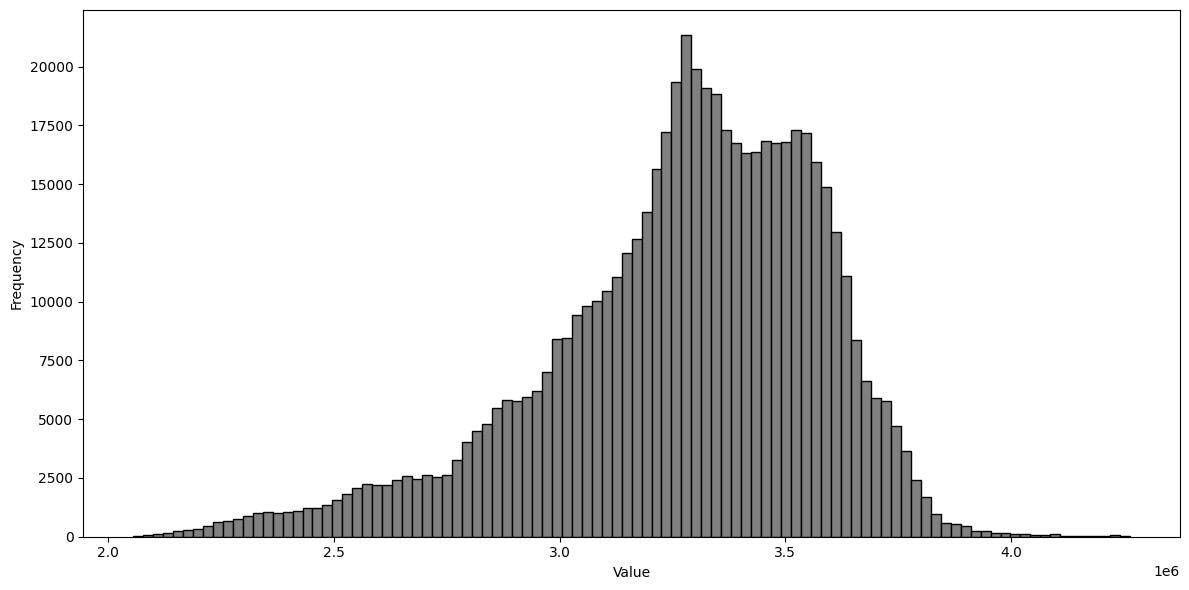

In [51]:
# investigate distribution of A1
feature = df.columns[0] 
plt.figure(figsize=(12, 6))
df[feature].hist(bins=100, edgecolor='black', color='grey')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.grid(False)
plt.tight_layout()
plt.show()

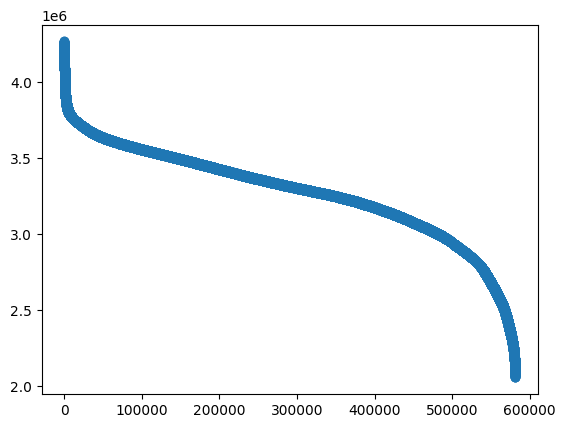

In [52]:
plt.scatter(df[60], df[0])

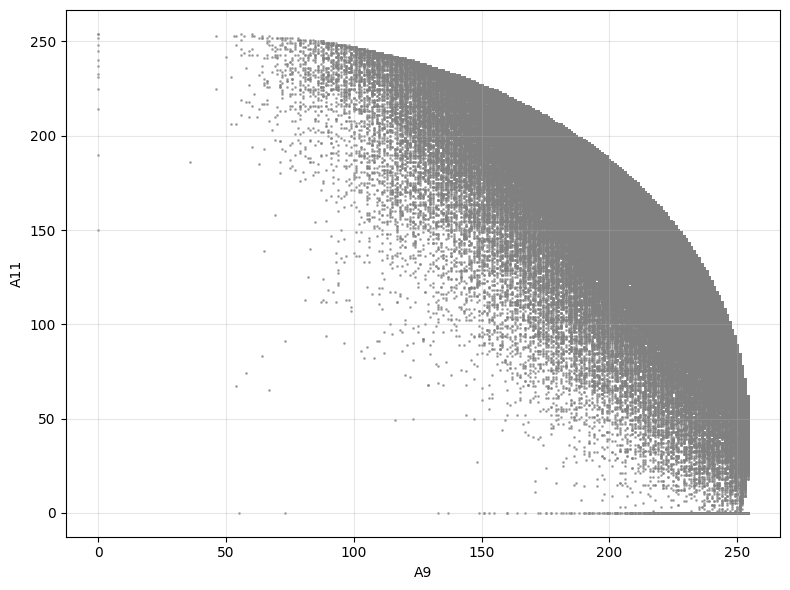

In [53]:
plt.figure(figsize=(8, 6))
plt.scatter(df[8], df[10], s=1, alpha=0.6, color='grey', rasterized=True)
plt.xlabel('A9')
plt.ylabel('A11')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('report/images/A9_A11_scatter.pdf', dpi=300)
plt.show()

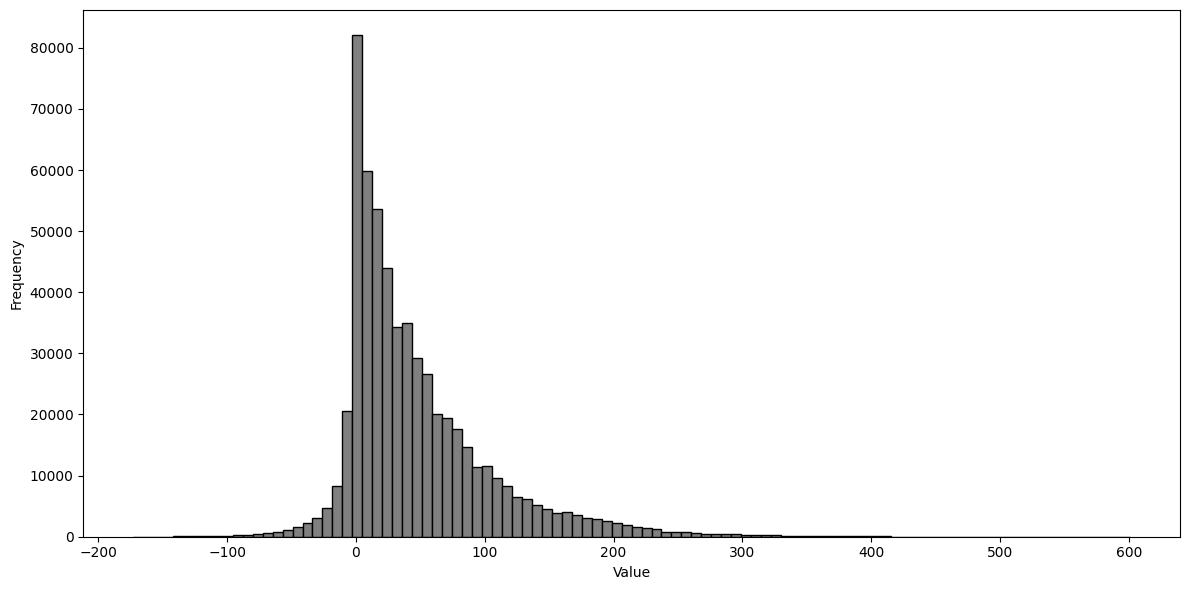

In [54]:
# plot distribution of A6
feature = df.columns[5] 
plt.figure(figsize=(12, 6))
df[feature].hist(bins=100, edgecolor='black', color='grey')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.grid(False)
plt.tight_layout()
plt.show()

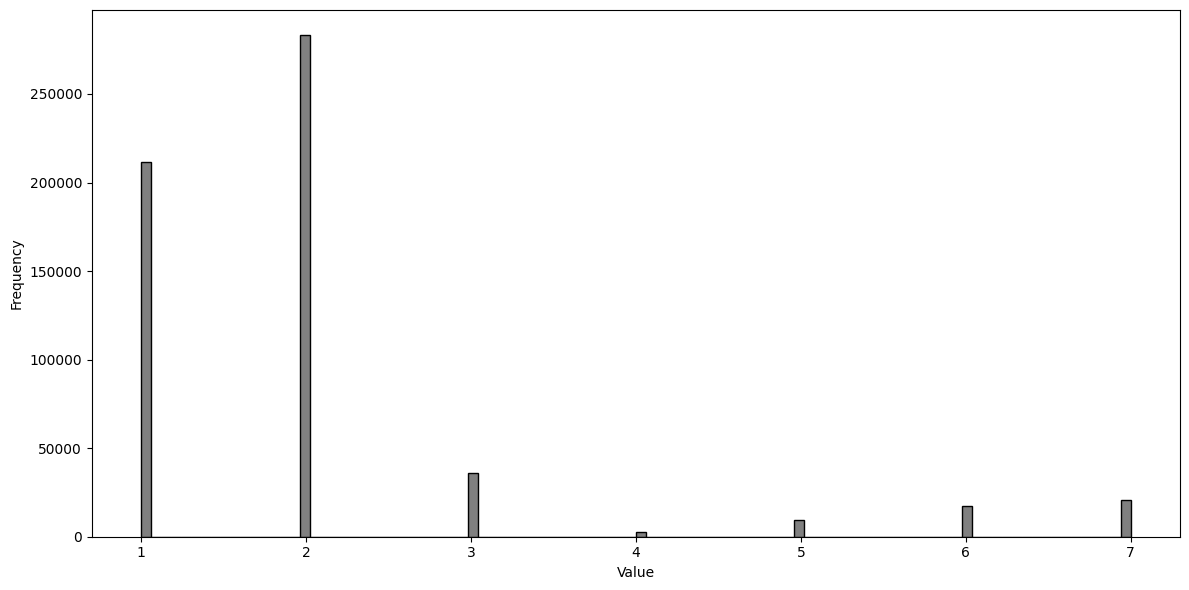

In [55]:
# plot distribution of target
feature = df.columns[62] 
plt.figure(figsize=(12, 6))
df[feature].hist(bins=100, edgecolor='black', color='grey')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.grid(False)
plt.tight_layout()
plt.show()

## Correlation Analysis

Below we'll analyze the correlations between features and create a table with the 10 highest correlations.

In [56]:
# Calculate correlation matrix for continuous features
correlation_matrix = df_continuous.corr()

# Create a mask to exclude self-correlations (diagonal) and duplicate pairs
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool), k=1)

# Extract the upper triangle correlations (excluding diagonal)
correlations_flat = correlation_matrix.where(mask).stack()

# Sort correlations by absolute value to get strongest relationships
correlations_sorted = correlations_flat.reindex(correlations_flat.abs().sort_values(ascending=False).index)

# Get the top 10 highest correlations
top_10_correlations = correlations_sorted.head(10)

print("Top 10 Highest Correlations (by absolute value):")
print("=" * 60)
for (feature1, feature2), correlation in top_10_correlations.items():
    print(f"{feature1:>3} & {feature2:>3}: {correlation:>8.4f}")

Top 10 Highest Correlations (by absolute value):
  1 &   2:   1.0000
  0 &  60:  -0.9522
  8 &  10:  -0.7803
  1 &  10:   0.6469
  2 &  10:   0.6469
  4 &   5:   0.6059
  1 &   8:  -0.5793
  2 &   8:  -0.5792
  3 &   8:  -0.3272
  4 &  60:  -0.3112


In [57]:
# Create a formatted table with the top 10 correlations
correlation_table = pd.DataFrame({
    'Feature 1': [f'A{pair[0]+1}' for pair in top_10_correlations.index],
    'Feature 2': [f'A{pair[1]+1}' for pair in top_10_correlations.index],
    'Correlation': top_10_correlations.values,
    'Absolute Correlation': top_10_correlations.abs().values
})

print("\nTop 10 Highest Correlations Table:")
print("=" * 80)
print(correlation_table.to_string(index=False, float_format='%.4f'))

# Display as a more readable formatted table
print("\n\nFormatted Correlation Table:")
print("=" * 80)
print(f"{'Rank':<4} {'Feature 1':<10} {'Feature 2':<10} {'Correlation':<12} {'|Correlation|':<15}")
print("-" * 80)
for i, ((f1, f2), corr) in enumerate(top_10_correlations.items(), 1):
    print(f"{i:<4} {f'A{f1+1}':<10} {f'A{f2+1}':<10} {corr:<12.4f} {abs(corr):<15.4f}")


Top 10 Highest Correlations Table:
Feature 1 Feature 2  Correlation  Absolute Correlation
       A2        A3       1.0000                1.0000
       A1       A61      -0.9522                0.9522
       A9       A11      -0.7803                0.7803
       A2       A11       0.6469                0.6469
       A3       A11       0.6469                0.6469
       A5        A6       0.6059                0.6059
       A2        A9      -0.5793                0.5793
       A3        A9      -0.5792                0.5792
       A4        A9      -0.3272                0.3272
       A5       A61      -0.3112                0.3112


Formatted Correlation Table:
Rank Feature 1  Feature 2  Correlation  |Correlation|  
--------------------------------------------------------------------------------
1    A2         A3         1.0000       1.0000         
2    A1         A61        -0.9522      0.9522         
3    A9         A11        -0.7803      0.7803         
4    A2         A11    

In [58]:
# Generate LaTeX table for the top 10 correlations (for report inclusion)
def correlation_table_latex(correlations, caption="Top 10 Highest Correlations", label="tab:top_correlations"):
    """
    Generate a LaTeX table for the top correlations.
    """
    data = []
    for i, ((f1, f2), corr) in enumerate(correlations.items(), 1):
        data.append([i, f'A{f1+1}', f'A{f2+1}', corr, abs(corr)])
    
    df_table = pd.DataFrame(data, columns=[
        'Rank', 'Feature 1', 'Feature 2', 'Correlation', '|Correlation|'
    ])
    
    latex = df_table.to_latex(
        index=False,
        float_format="%.4f",
        column_format="|c|c|c|r|r|",
        caption=caption,
        label=label,
        escape=False
    )
    
    return latex

# Generate and display the LaTeX table
latex_corr_table = correlation_table_latex(top_10_correlations)
print("\nLaTeX Table for Report:")
print("=" * 80)
print(latex_corr_table)


LaTeX Table for Report:
\begin{table}
\caption{Top 10 Highest Correlations}
\label{tab:top_correlations}
\begin{tabular}{|c|c|c|r|r|}
\toprule
Rank & Feature 1 & Feature 2 & Correlation & |Correlation| \\
\midrule
1 & A2 & A3 & 1.0000 & 1.0000 \\
2 & A1 & A61 & -0.9522 & 0.9522 \\
3 & A9 & A11 & -0.7803 & 0.7803 \\
4 & A2 & A11 & 0.6469 & 0.6469 \\
5 & A3 & A11 & 0.6469 & 0.6469 \\
6 & A5 & A6 & 0.6059 & 0.6059 \\
7 & A2 & A9 & -0.5793 & 0.5793 \\
8 & A3 & A9 & -0.5792 & 0.5792 \\
9 & A4 & A9 & -0.3272 & 0.3272 \\
10 & A5 & A61 & -0.3112 & 0.3112 \\
\bottomrule
\end{tabular}
\end{table}



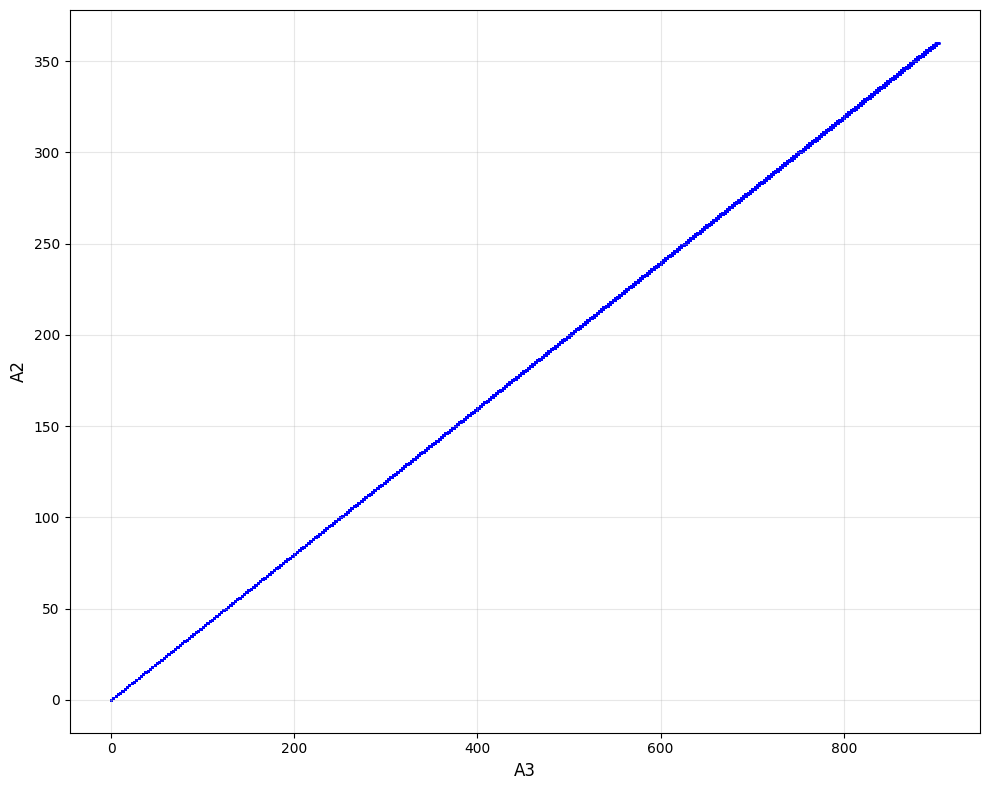

In [59]:
# scatter plot A2 vs A3 with A3 on x-axis and A2 on y-axis
plt.figure(figsize=(10, 8))
plt.scatter(df[2], df[1], alpha=0.6, s=1, color='blue')
plt.xlabel('A3', fontsize=12)
plt.ylabel('A2', fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('report/images/A2_vs_A3_scatter.pdf', dpi=300)
plt.show()

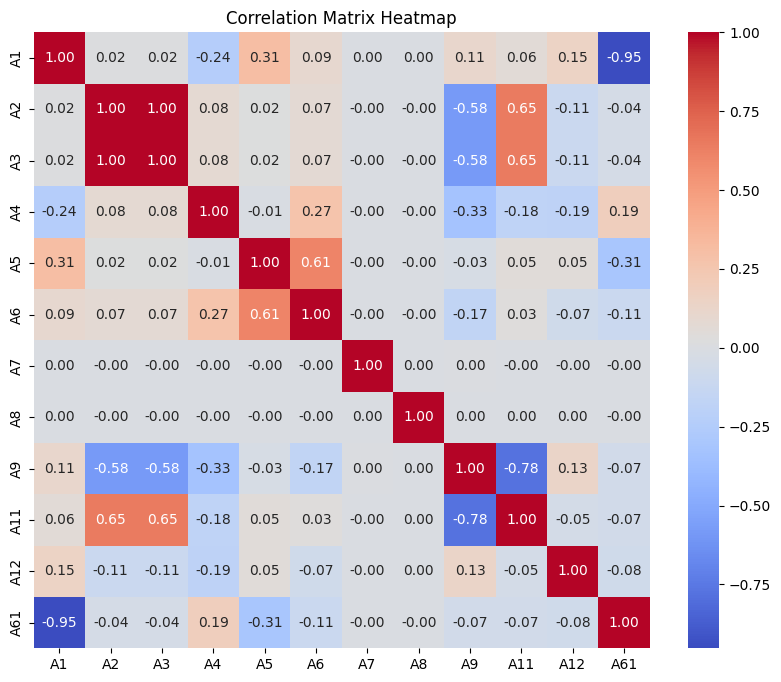

In [60]:
# make correlation matrix heatmap 
corr = df_continuous.corr()

# Create A labels for the features (A1, A2, etc.)
feature_labels = [f'A{col+1}' for col in corr.index]

plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm', square=True, 
            xticklabels=feature_labels, yticklabels=feature_labels)
plt.title('Correlation Matrix Heatmap')
plt.savefig('report/images/correlation_matrix_heatmap.pdf', dpi=300)
plt.show()

In [61]:
# find observations in the dataset that have more than 2 missing values
missing_values = df.isnull().sum(axis=1)
observations_with_missing_values = df[missing_values > 2]

In [62]:
observations_with_missing_values

,0,1,2,3,4,5,6,7,8,9,...,53,54,55,56,57,58,59,60,61,62
136,4211383.50,NaN,884.594833,13.0,NaN,363.949688,NaN,4903,NaN,NaN,...,0,0,0,0,0,0,1,137,1,7.0
432,4090900.35,NaN,20.039133,14.0,NaN,292.001455,NaN,4984,NaN,NaN,...,0,0,0,0,0,0,1,433,1,7.0
439,4089795.00,NaN,57.722647,7.0,NaN,290.969881,NaN,5143,NaN,NaN,...,0,0,0,0,0,0,1,440,1,7.0
539,4057739.85,NaN,350.683825,11.0,NaN,416.046630,NaN,2649,NaN,NaN,...,0,0,0,0,0,0,1,540,1,1.0
543,4056634.50,NaN,262.694991,13.0,NaN,415.015105,NaN,2609,NaN,NaN,...,0,0,0,0,0,0,1,544,1,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
579884,2201857.20,NaN,147.756315,33.0,NaN,141.056575,NaN,309,NaN,NaN,...,0,0,0,0,0,0,0,579885,1,6.0
579969,2197435.80,NaN,60.048579,32.0,NaN,142.047105,NaN,218,NaN,NaN,...,0,0,0,0,0,0,0,579970,1,6.0
580300,2173118.10,NaN,242.802167,8.0,NaN,0.053505,NaN,201,NaN,NaN,...,0,0,0,0,0,0,0,580301,1,3.0
580400,2166486.00,NaN,27.544283,30.0,NaN,0.049417,NaN,60,NaN,NaN,...,0,0,0,0,0,0,0,580401,1,3.0


In [63]:
# get features affected by missing values
affected_features = observations_with_missing_values.columns[observations_with_missing_values.isnull().any()].tolist() 
affected_features


[1, 3, 4, 6, 8, 9, 11, 12, 15, 17, 19, 20]

In [64]:
affected_features = [f"A{int(f) + 1}" for f in affected_features]
affected_features


['A2', 'A4', 'A5', 'A7', 'A9', 'A10', 'A12', 'A13', 'A16', 'A18', 'A20', 'A21']

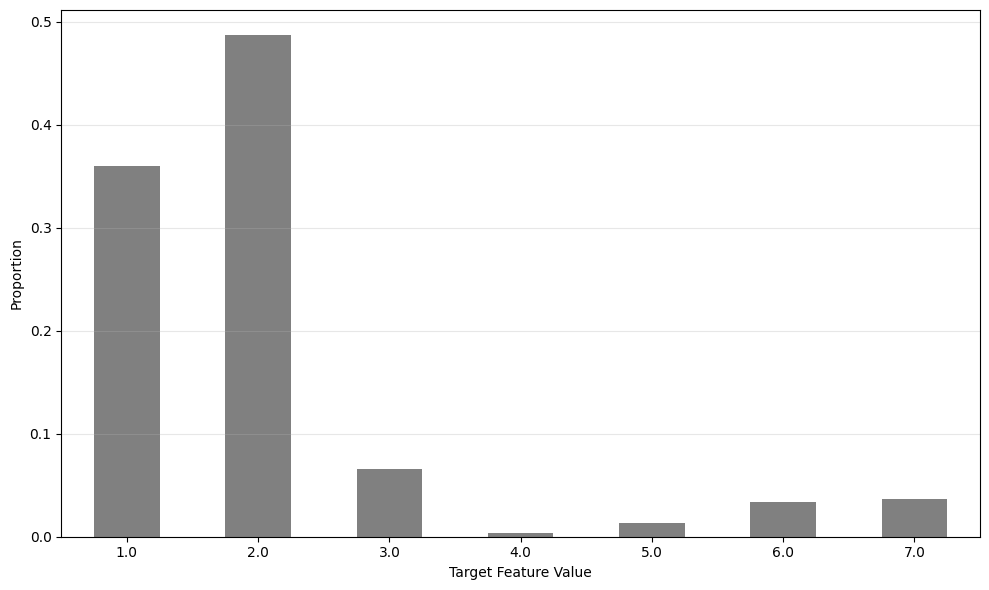

In [65]:
# check distribution of target feature in observations with missing values vs entire dataset
target_feature_distribution_missing = observations_with_missing_values[62].value_counts(normalize=True).sort_index()
target_feature_distribution_entire = df[62].value_counts(normalize=True).sort_index()

# Plot 1: Distribution for observations with missing values
plt.figure(figsize=(10, 6))
target_feature_distribution_missing.plot(kind='bar', color='grey')
plt.xlabel('Target Feature Value')
plt.ylabel('Proportion')
plt.xticks(rotation=0)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.savefig('report/images/target_feature_distribution_missing.pdf', dpi=300, bbox_inches='tight')
plt.show()

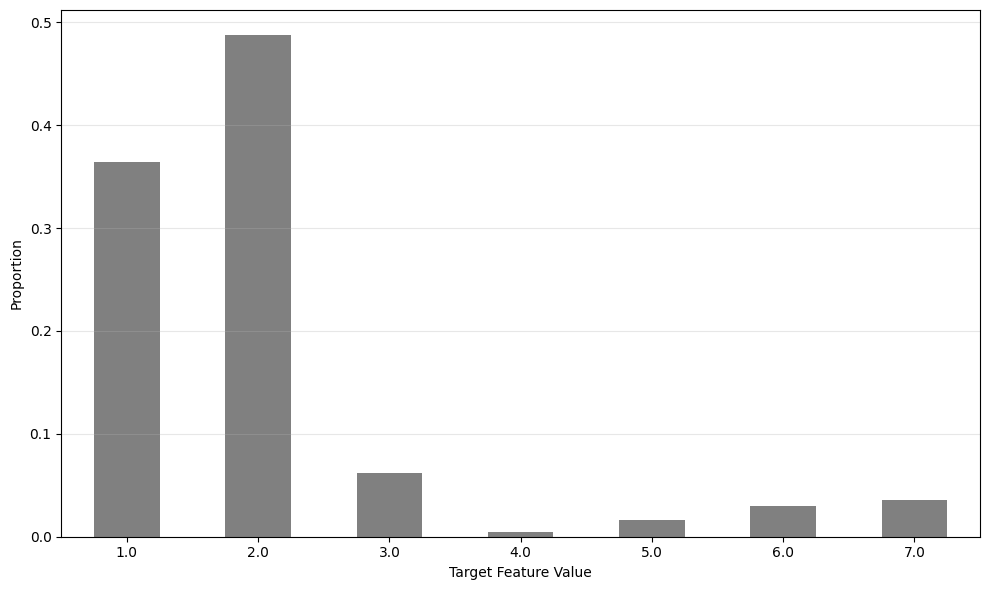

In [66]:


# Plot 2: Distribution for entire dataset
plt.figure(figsize=(10, 6))
target_feature_distribution_entire.plot(kind='bar', color='grey')
plt.xlabel('Target Feature Value')
plt.ylabel('Proportion')
plt.xticks(rotation=0)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.savefig('report/images/target_feature_distribution_entire.pdf', dpi=300, bbox_inches='tight')
plt.show()

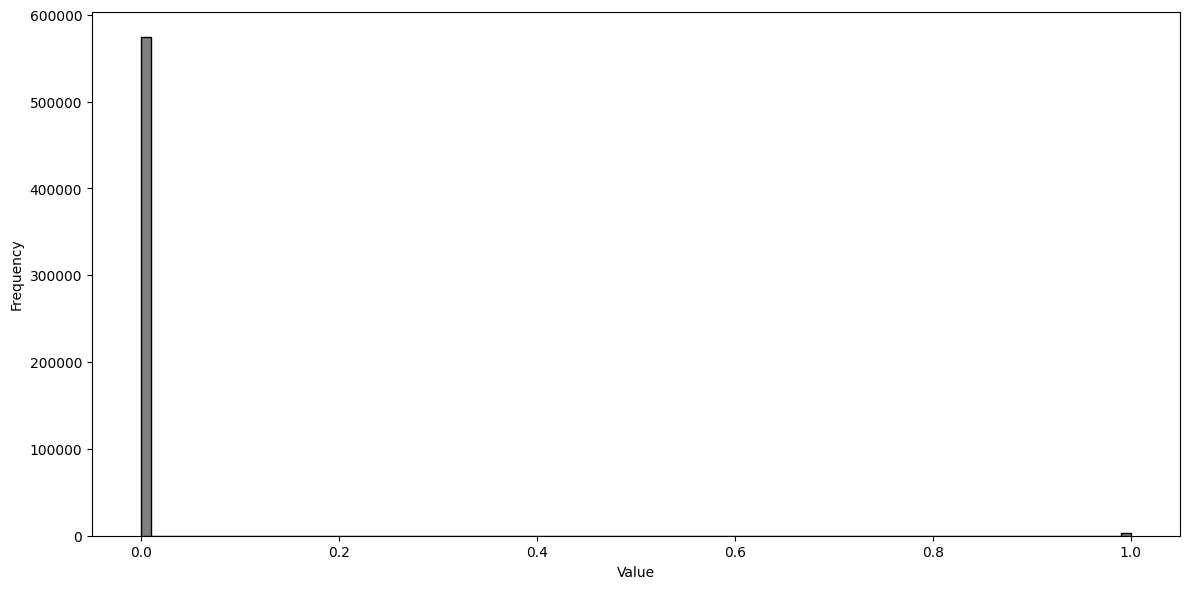

In [67]:
# distribution of feature 20
# plot distribution of A20
feature = df.columns[19] 
plt.figure(figsize=(12, 6))
df[feature].hist(bins=100, edgecolor='black', color='grey')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.grid(False)
plt.tight_layout()
plt.show()

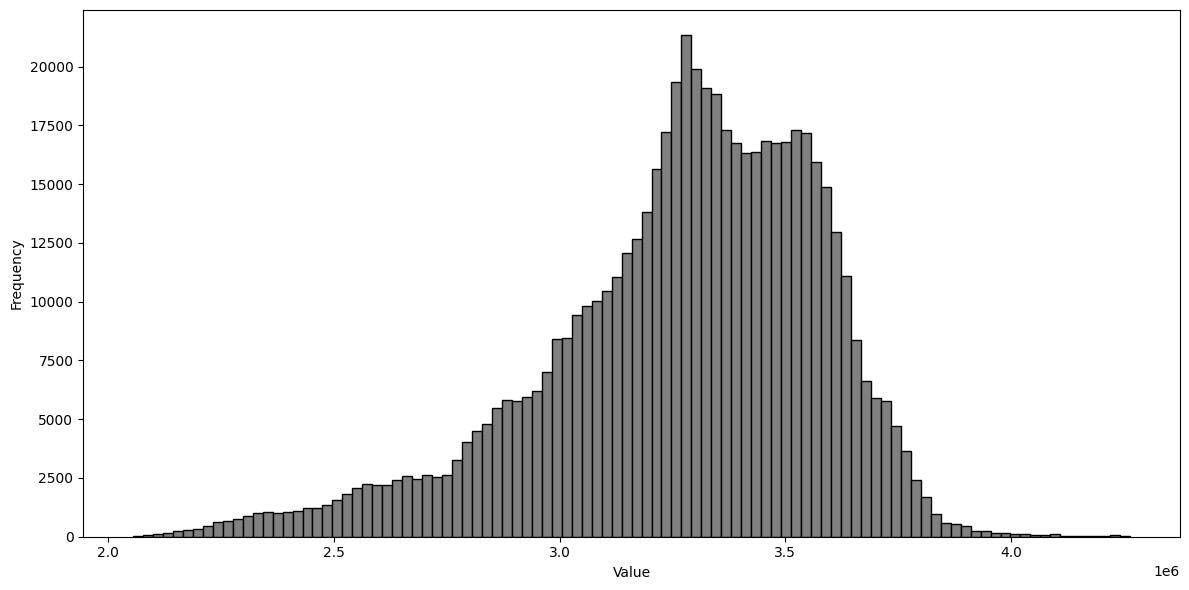

In [68]:
# distribution of feature 20
# plot distribution of A20
feature = df.columns[0] 
plt.figure(figsize=(12, 6))
df[feature].hist(bins=100, edgecolor='black', color='grey')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.grid(False)
plt.tight_layout()
plt.show()

In [69]:
# list all categorical features with primary class percentage >95% <100%

cat_features = df_categorical.columns
high_perc_features = []

for feature in cat_features:
    perc = df[feature].value_counts(normalize=True).max()
    if 0.95 < perc < 1.0:
        high_perc_features.append(feature)

high_perc_features

[19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 30,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 43,
 44,
 45,
 46,
 47,
 50,
 53,
 54,
 55,
 56,
 57,
 58,
 59]

In [70]:
# search for features with high cardinality and low correlation with target
high_cardinality_features = []
low_correlation_features = []

for feature in df.columns:
    # skip column 9
    if feature == 9:
        continue
    if df[feature].nunique() > 570000:  # High cardinality
        high_cardinality_features.append(feature)
    if df[feature].corr(df[62]) < 0.1:  # Low correlation
        low_correlation_features.append(feature)

high_cardinality_features, low_correlation_features

/usr/lib64/python3.13/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/usr/lib64/python3.13/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


([2, 5, 6, 60],
 [0,
  1,
  2,
  4,
  5,
  6,
  7,
  8,
  10,
  11,
  12,
  13,
  14,
  18,
  19,
  20,
  22,
  23,
  24,
  26,
  27,
  28,
  30,
  31,
  32,
  33,
  34,
  35,
  36,
  37,
  38,
  39,
  40,
  41,
  42,
  43,
  44,
  45,
  46,
  47,
  48,
  49,
  50,
  51,
  52,
  53,
  54,
  55,
  56])

In [71]:
# how many target features in class 3
df_target_class_3 = df[df[62] == 4]
df_target_class_3_count = df_target_class_3.shape[0]
df_target_class_3_count

2747

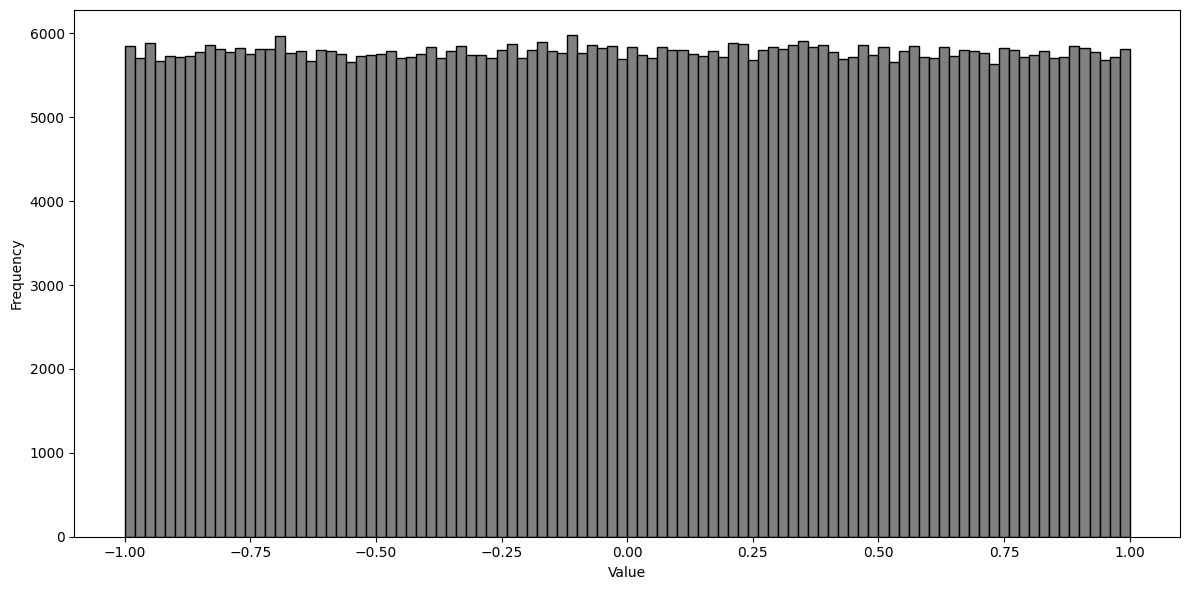

In [72]:
# a7

feature = df.columns[6] 
plt.figure(figsize=(12, 6))
df[feature].hist(bins=100, edgecolor='black', color='grey')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.grid(False)
plt.tight_layout()
plt.show()

In [73]:
# a7 correlation with target
df[62].corr(df[4])

-0.020129412518251833

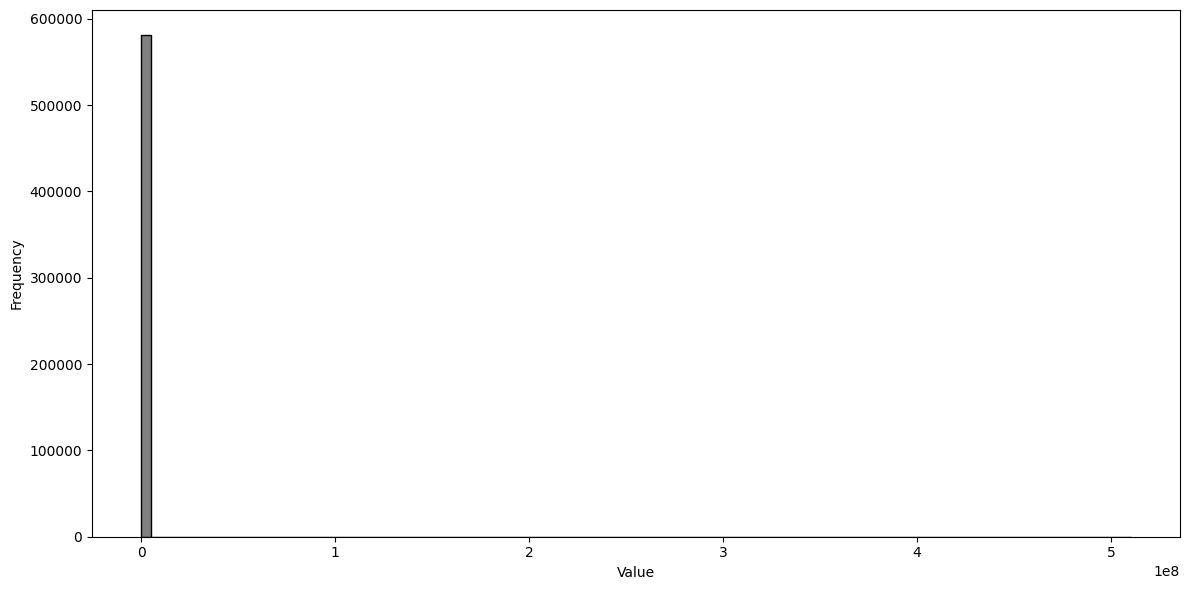

In [74]:
# a8
feature = df.columns[7] 
plt.figure(figsize=(12, 6))
df[feature].hist(bins=100, edgecolor='black', color='grey')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.grid(False)
plt.tight_layout()
plt.show()

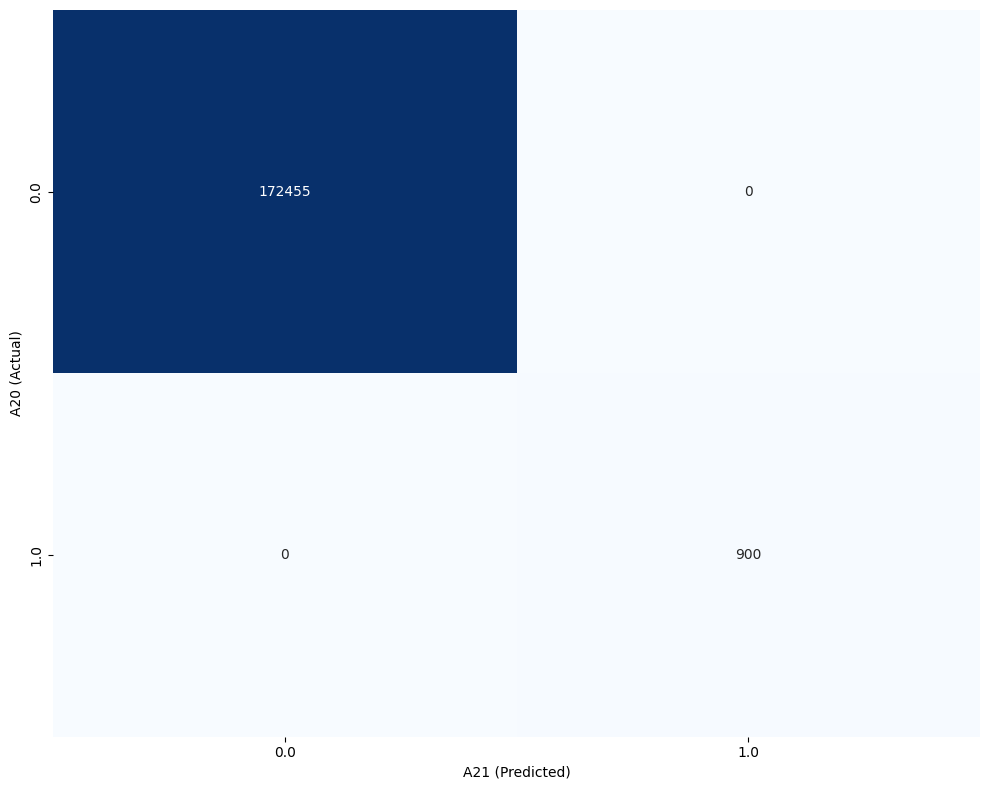

In [75]:
# plot confusion matrix between a21 and a20
from sklearn.metrics import confusion_matrix

# Get A20 and A21 data (columns 19 and 20, 0-indexed)
a20 = df[19]  # A20
a21 = df[20]  # A21

# Remove rows where either A20 or A21 is missing
mask = ~(a20.isna() | a21.isna())
a20_clean = a20[mask]
a21_clean = a21[mask]

# Create confusion matrix
cm = confusion_matrix(a20_clean, a21_clean)

# Create the plot
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=sorted(a21_clean.unique()), 
            yticklabels=sorted(a20_clean.unique()))
plt.xlabel('A21 (Predicted)')
plt.ylabel('A20 (Actual)')
plt.tight_layout()
plt.savefig('report/images/confusion_matrix_A20_A21.pdf', dpi=300, bbox_inches='tight')
plt.show()

In [76]:
# count missing values in target variable
missing_target_count = target_df.isna().sum()   
missing_target_count

0    60
dtype: int64

In [79]:
df.shape[0]

581012

In [80]:
60 / df.shape[0] * 100

0.01032680908483818

## Boxplots for Continuous Variables

Below we'll create boxplots for all continuous variables to visualize their distributions and identify potential outliers.

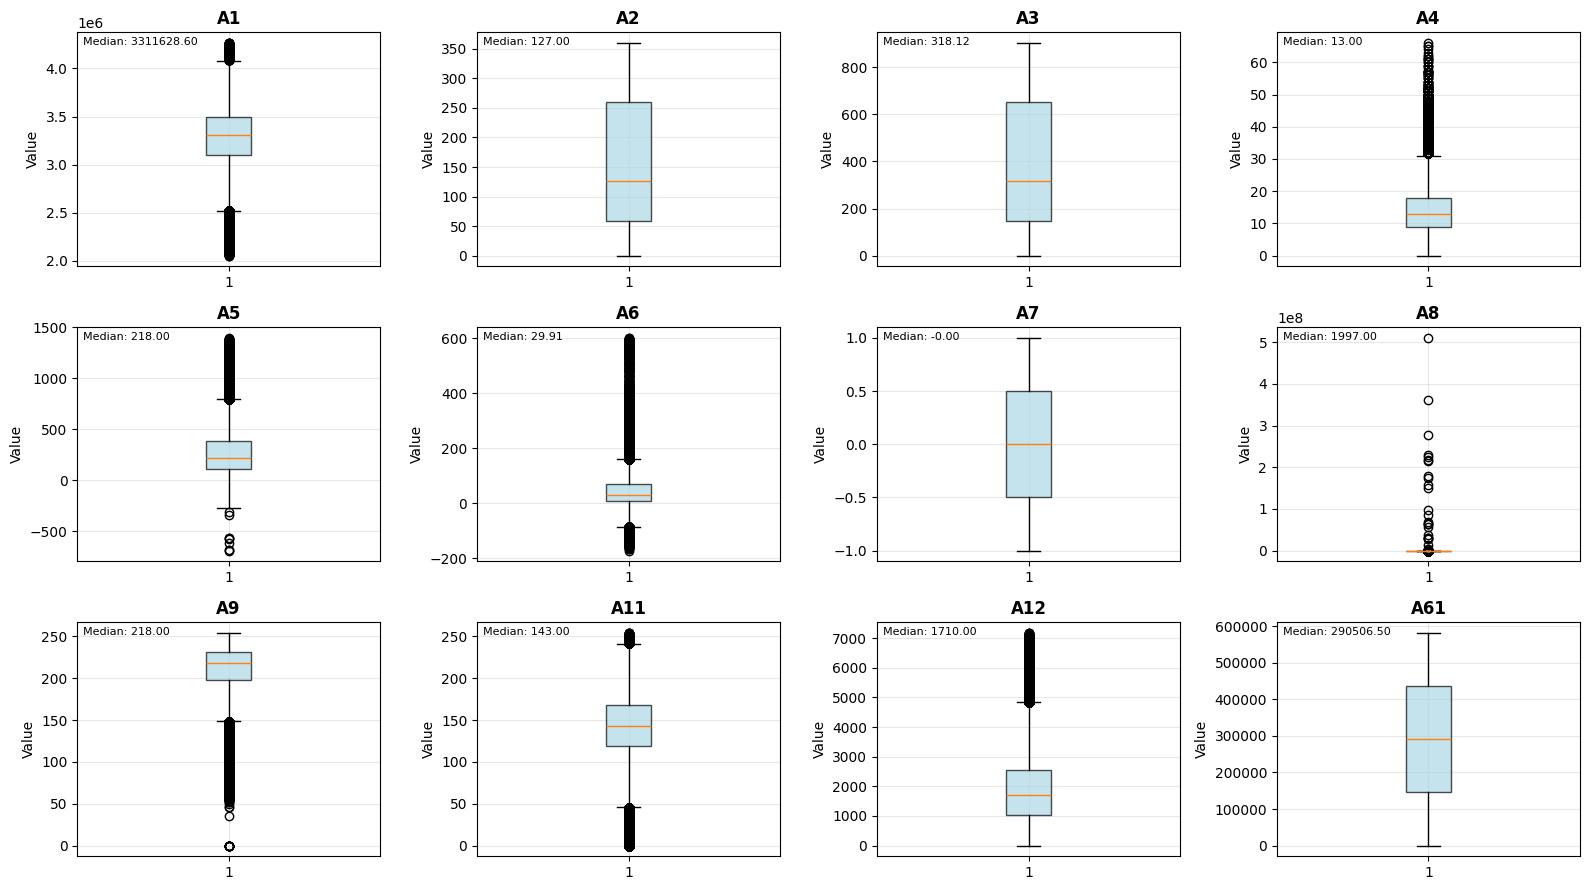

In [81]:
# Create individual boxplots for each continuous variable
continuous_features = df_continuous.columns
n_features = len(continuous_features)

# Calculate subplot dimensions (try to make roughly square)
n_cols = int(np.ceil(np.sqrt(n_features)))
n_rows = int(np.ceil(n_features / n_cols))

plt.figure(figsize=(4 * n_cols, 3 * n_rows))

for i, feature in enumerate(continuous_features):
    plt.subplot(n_rows, n_cols, i + 1)
    
    # Create boxplot
    box_plot = plt.boxplot(df[feature].dropna(), patch_artist=True)
    
    # Customize colors
    box_plot['boxes'][0].set_facecolor('lightblue')
    box_plot['boxes'][0].set_alpha(0.7)
    
    plt.title(f'A{feature + 1}', fontsize=12, fontweight='bold')
    plt.ylabel('Value')
    plt.grid(True, alpha=0.3)
    
    # Add some statistics as text
    stats = df[feature].describe()
    plt.text(0.02, 0.98, f'Median: {stats["50%"]:.2f}', 
             transform=plt.gca().transAxes, verticalalignment='top', fontsize=8)

plt.tight_layout()
plt.savefig('report/images/continuous_variables_boxplots.pdf', dpi=300, bbox_inches='tight')
plt.show()

/tmp/ipykernel_7394/1469711414.py:13: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box_plot = plt.boxplot(continuous_data, labels=continuous_labels, patch_artist=True)


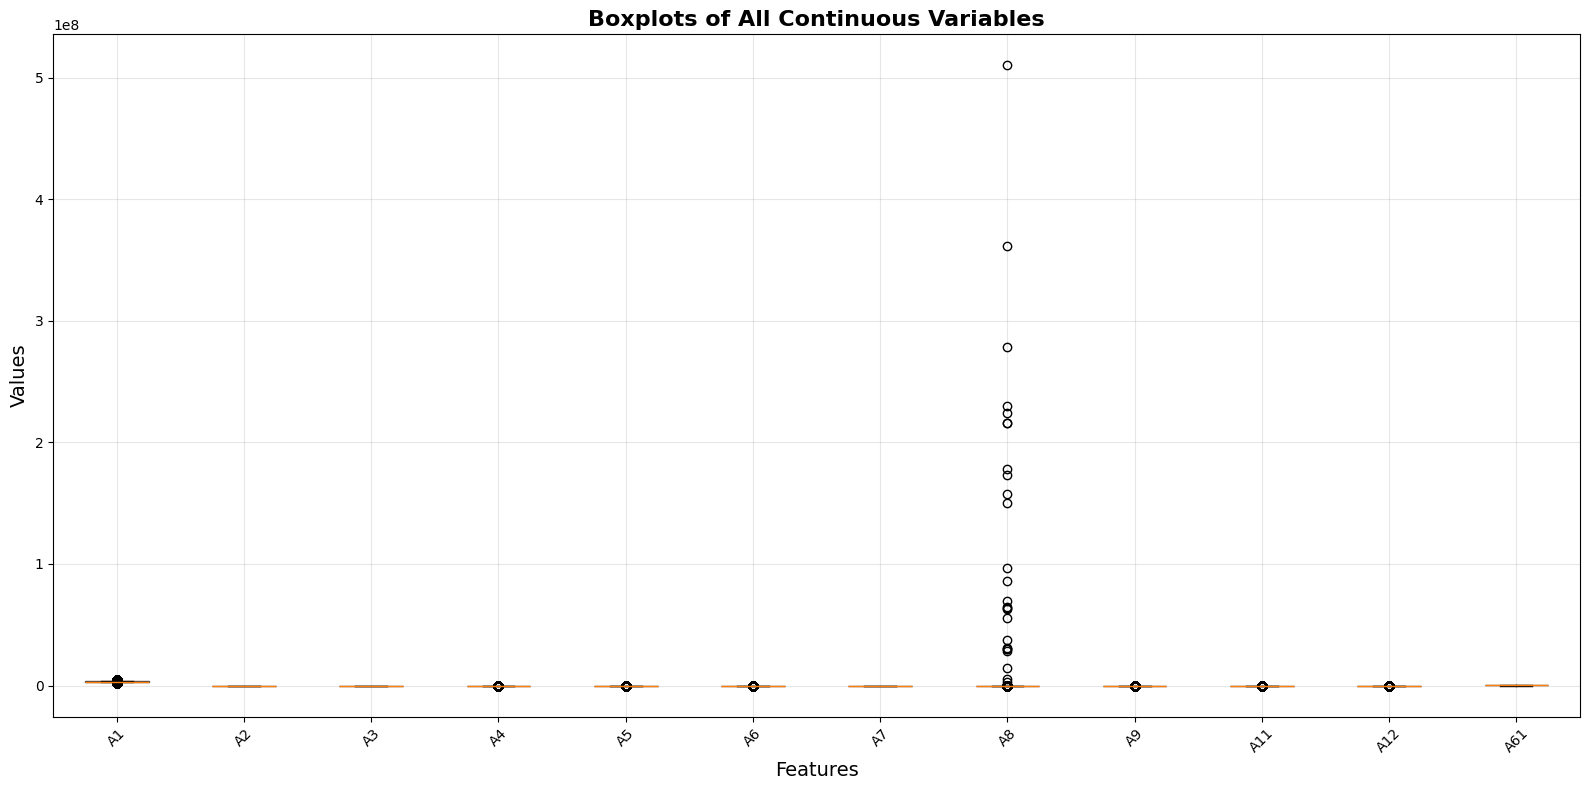

In [ ]:
# Create side-by-side boxplots for easier comparison
plt.figure(figsize=(16, 8))

# Prepare data for side-by-side comparison
continuous_data = []
continuous_labels = []

for feature in continuous_features:
    continuous_data.append(df[feature].dropna().values)
    continuous_labels.append(f'A{feature + 1}')

# Create the boxplot
box_plot = plt.boxplot(continuous_data, labels=continuous_labels, patch_artist=True)

# Customize colors - alternate between two colors for better visibility
colors = ['lightblue', 'lightcoral']
for i, box in enumerate(box_plot['boxes']):
    box.set_facecolor(colors[i % 2])
    box.set_alpha(0.7)

plt.title('Boxplots of All Continuous Variables', fontsize=16, fontweight='bold')
plt.xlabel('Features', fontsize=14)
plt.ylabel('Values', fontsize=14)
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('report/images/continuous_variables_boxplots_comparison.pdf', dpi=300, bbox_inches='tight')
plt.show()

/tmp/ipykernel_7394/850079739.py:22: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box_plot = plt.boxplot(normalized_data, labels=normalized_labels, patch_artist=True)


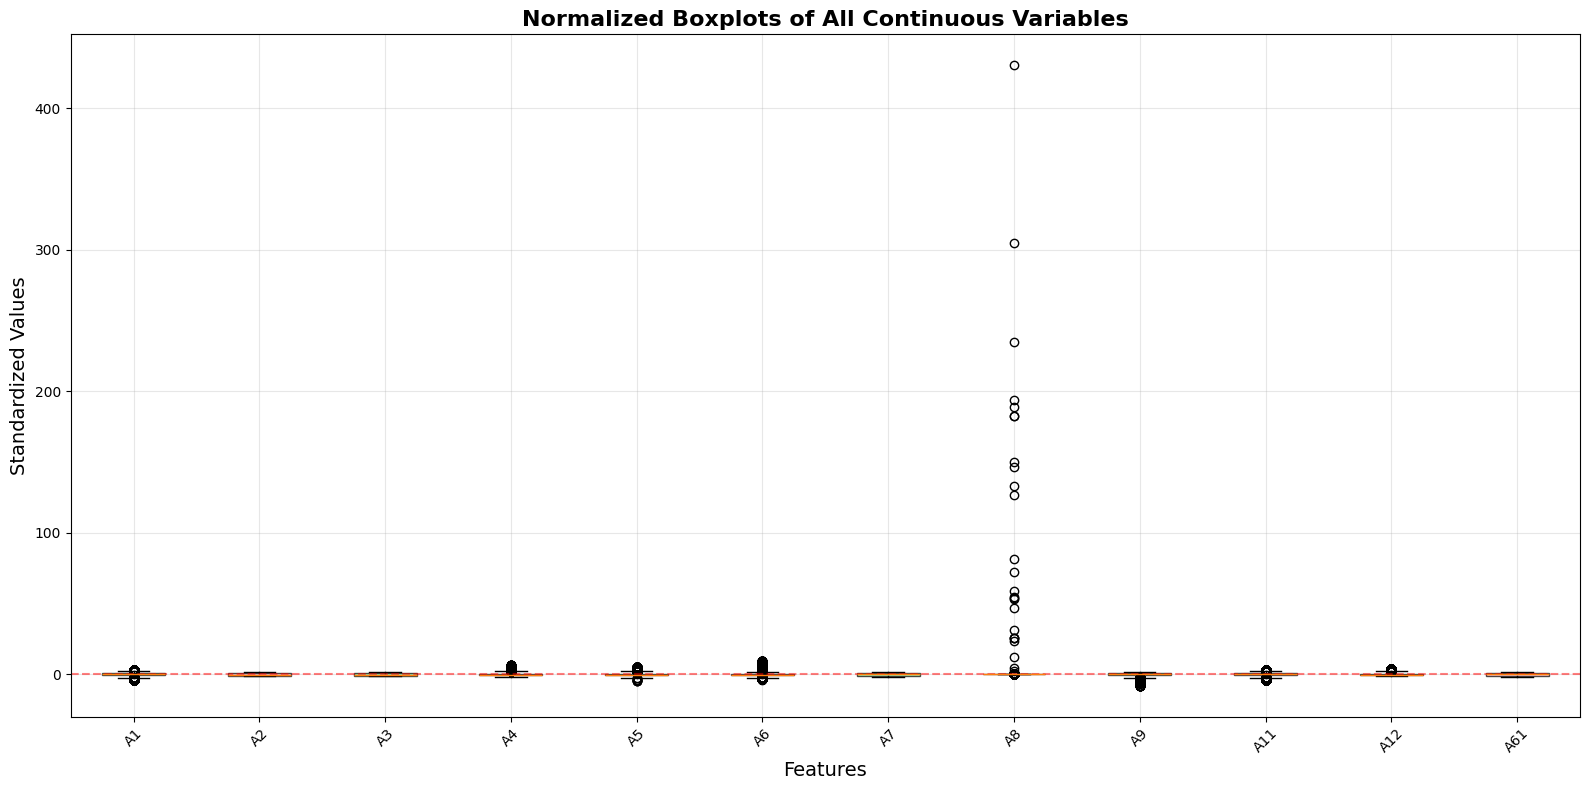

In [83]:
# Create normalized boxplots to handle different scales better
from sklearn.preprocessing import StandardScaler

plt.figure(figsize=(16, 8))

# Normalize the continuous features for better comparison
scaler = StandardScaler()
df_continuous_normalized = pd.DataFrame(
    scaler.fit_transform(df_continuous), 
    columns=df_continuous.columns
)

# Prepare normalized data for boxplot
normalized_data = []
normalized_labels = []

for feature in continuous_features:
    normalized_data.append(df_continuous_normalized[feature].dropna().values)
    normalized_labels.append(f'A{feature + 1}')

# Create the normalized boxplot
box_plot = plt.boxplot(normalized_data, labels=normalized_labels, patch_artist=True)

# Customize colors
colors = ['lightgreen', 'lightpink']
for i, box in enumerate(box_plot['boxes']):
    box.set_facecolor(colors[i % 2])
    box.set_alpha(0.7)

plt.title('Normalized Boxplots of All Continuous Variables', fontsize=16, fontweight='bold')
plt.xlabel('Features', fontsize=14)
plt.ylabel('Standardized Values', fontsize=14)
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)
plt.axhline(y=0, color='red', linestyle='--', alpha=0.5)  # Add reference line at 0
plt.tight_layout()
plt.savefig('report/images/continuous_variables_boxplots_normalized.pdf', dpi=300, bbox_inches='tight')
plt.show()

In [85]:
# Analyze outliers for each continuous variable based on IQR method
print("Outlier Analysis for Continuous Variables")
print("=" * 60)

outlier_summary = []

for feature in continuous_features:
    data = df[feature].dropna()
    
    # Calculate IQR
    Q1 = data.quantile(0.25)
    Q3 = data.quantile(0.75)
    IQR = Q3 - Q1
    
    # Define outlier bounds
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # Count outliers
    outliers = data[(data < lower_bound) | (data > upper_bound)]
    outlier_count = len(outliers)
    outlier_percentage = (outlier_count / len(data)) * 100
    
    outlier_summary.append({
        'Feature': f'A{feature + 1}',
        'Total_Count': len(data),
        'Outlier_Count': outlier_count,
        'Outlier_Percentage': outlier_percentage,
        'Lower_Bound': lower_bound,
        'Upper_Bound': upper_bound,
        'Q1': Q1,
        'Q3': Q3,
        'IQR': IQR
    })
    
    print(f"A{feature + 1:>2}: {outlier_count:>4} outliers ({outlier_percentage:>5.1f}%) out of {len(data):>6} observations")

# Convert to DataFrame for easier viewing
outlier_df = pd.DataFrame(outlier_summary)
print(f"\nSummary: {outlier_df['Outlier_Count'].sum()} total outliers across all continuous features")
print(f"Average outlier percentage: {outlier_df['Outlier_Percentage'].mean():.2f}%")

Outlier Analysis for Continuous Variables
A 1: 15574 outliers (  2.7%) out of 581012 observations
A 2:    0 outliers (  0.0%) out of 578069 observations
A 3:    0 outliers (  0.0%) out of 581012 observations
A 4: 15309 outliers (  2.6%) out of 580708 observations
A 5: 14488 outliers (  2.5%) out of 578069 observations
A 6: 31921 outliers (  5.5%) out of 581012 observations
A 7:    0 outliers (  0.0%) out of 578069 observations
A 8:  695 outliers (  0.1%) out of 581012 observations
A 9: 17338 outliers (  3.0%) out of 578069 observations
A11: 7832 outliers (  1.3%) out of 581012 observations
A12: 31021 outliers (  5.4%) out of 578069 observations
A61:    0 outliers (  0.0%) out of 581012 observations

Summary: 134178 total outliers across all continuous features
Average outlier percentage: 1.93%
